# Histograms for host galaxy properties

This notebook creates histograms plotting pew and velocity binned by the median of individual host gal properties. These are created for individual features. They also show anderson darling p values. 

It creates a plot of p values as the binning cutoff moves from the median. 

It removes certain outliers from the branch classification plot and host gal property plots in the phase_evolution notebook and observes how the p value changes, provided in a dataframe. 

### imports

In [17]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats
from sndata.csp import DR3
from sndata.sdss import Sako18Spec

In [18]:
feature_alias = {
    'pW1': 'Ca ii H&K',
    'pW2': 'Si ii λ4130',
    'pW3': 'Mg ii, Fe ii',
    'pW4': 'Fe ii, Si ii',
    'pW5': 'S ii λ5449, λ5622',
    'pW6': 'Si ii λ5972',
    'pW7': 'Si ii λ6355',
    'pW8': 'Ca ii IR triplet'}

In [19]:
sdss_combined = pd.read_csv('~/Desktop/Research/SN-Spectral-Evolution/results/sdss_combined.csv')
sdss_combined

,feat_name,obj_id,time,feat_start,feat_end,vel,vel_err,vel_samperr,pew,pew_err,...,agePEGASE,ageloPEGASE,agehiPEGASE,minchi2PEGASE,Notes,delta_t,is_peak,branch_type,arcmin,kpc
0,pW6,19128,2454387.5,5630.787447,5932.631261,8144.168668,0.0,341.659397,16.352920,0.0,...,NaN,NaN,NaN,NaN,NaN,0.1,True,BL,NaN,NaN
1,pW2,2017,2453636.5,3908.025238,4040.182181,NaN,0.0,NaN,17.092118,0.0,...,1.25,1.08,1.39,0.14,NaN,0.1,True,SS,0.034500,43.077351
2,pW1,2017,2453636.5,3615.136877,3908.025238,13865.174056,0.0,323.138916,52.658139,0.0,...,1.25,1.08,1.39,0.14,NaN,0.1,True,SS,0.034500,43.077351
3,pW2,19128,2454387.5,3942.640340,4073.335600,8793.661154,0.0,735.823388,8.520702,0.0,...,NaN,NaN,NaN,NaN,NaN,0.1,True,BL,NaN,NaN
4,pW1,2689,2453637.5,3657.035407,3918.106397,11820.961436,0.0,443.806031,103.331980,0.0,...,5.58,4.75,9.70,6.98,NaN,0.1,True,NaN,0.049833,62.012352
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
796,pW7,2165,2453641.5,5919.931260,6572.577243,9137.197106,0.0,241.346074,209.514632,0.0,...,0.86,0.03,4.07,8.78,NaN,6.7,True,CL,0.012000,15.057214
797,pW1,19968,2454406.5,3507.901777,3921.776287,17654.228010,0.0,76.274254,158.092375,0.0,...,2.41,2.41,2.72,61.46,NaN,6.8,True,SS,0.027500,34.389803
798,pW3,8719,2453683.5,4084.014864,4480.981091,14043.481108,0.0,229.733128,70.137655,0.0,...,0.20,0.08,0.64,5.96,NaN,7.0,True,NaN,0.029333,36.667727
799,pW1,8719,2453683.5,3552.557347,3932.169859,16685.149802,0.0,230.510419,134.423657,0.0,...,0.20,0.08,0.64,5.96,NaN,7.0,True,NaN,0.029333,36.667727


In [84]:
branch_outliers = [10449, 16021, 1371, 6773, 7147, 16099, 16281, 18375, 18697, 21502]
redshift_outliers = [16280, 3901, 17825, 2330, 1580, 15369, 13072, 5737, 5994, 16287,
                     6422, 6933, 16333]
hostmass_outliers = [16280, 3901, 2330, 1580, 15369, 6422, 13072, 16333]
sfr_outliers = [1580, 1253, 20350, 16280, 16333]

In [21]:
def remove_outliers(outliers, df):
    """removes outliers from a dataframe

    Args:
        outliers (list): list of int describing object IDs that are outliers
        df (df): dataframe the outliers are to be removed from

    Returns:
        df (df): inputted dataframe without outliers
    """
    for outlier in outliers:
        for obj in df['obj_id']:
            if obj == outlier:
                #breakpoint()
                i = df.loc[df['obj_id'] == obj].index[0]
                df = df.drop(i)
            else:
                continue
    return df

In [86]:
no_branch_out = remove_outliers(branch_outliers, sdss_combined)
no_zCMB_out = remove_outliers(redshift_outliers, sdss_combined)
no_mass_out = remove_outliers(hostmass_outliers, sdss_combined)
no_sfr_out = remove_outliers(sfr_outliers, sdss_combined)

no_out = remove_outliers(branch_outliers, sdss_combined)
no_out = remove_outliers(redshift_outliers, no_out)
no_out = remove_outliers(hostmass_outliers, no_out)
no_out = remove_outliers(sfr_outliers, no_out)

### creating indexed dataframes of binned data by median

In [28]:
def feat_hist(df):
    ''' breaks up a df by feature
    
    Args:
        df:    (df) df we want to divide
    
    Returns: 
        hist_list:   (list) list of data frames for individual features
    '''
    
    hist_list = []
    for i in range(1,9):
        new_hist = df[df['feat_name'] == f'pW{i}']
        hist_list.append(new_hist)
    return hist_list

In [31]:
def create_high_low(df):
    """creates binned high and low data for histograms (binned by median of host gal prop)

    Args:
        df (df): dataframe of data

    Returns:
        high_zCMB: (df) high redshift data
        low_zCMB: (df) low redshift data
        high_logMass: (df) high mass data
        low_logMass: (df) low mass data
        high_logSSFR: (df) high SFR data
        low_logSSFR: (df) low SFR data
    """
    zCMB = df['zCMB'].dropna()
    logMass = df['logMassFSPS'].dropna()
    logSSFR = df['logSSFRFSPS'].dropna()

    med_zCMB = np.median(zCMB)
    med_logMass = 10
    med_logSSFR = np.median(logSSFR)

    high_zCMB = df[df['zCMB'] > med_zCMB]
    low_zCMB = df[df['zCMB'] <= med_zCMB]
    high_logMass = df[df['logMassFSPS'] > med_logMass]
    low_logMass = df[df['logMassFSPS'] <= med_logMass]
    high_logSSFR = df[df['logSSFRFSPS'] > med_logSSFR]
    low_logSSFR = df[df['logSSFRFSPS'] <= med_logSSFR]
    
    high_zCMB = feat_hist(high_zCMB)
    low_zCMB = feat_hist(low_zCMB)
    high_logMass = feat_hist(high_logMass)
    low_logMass = feat_hist(low_logMass)
    high_logSSFR = feat_hist(high_logSSFR)
    low_logSSFR = feat_hist(low_logSSFR)

    high_zCMB = high_zCMB[:-1]
    low_zCMB = low_zCMB[:-1]
    high_logMass = high_logMass[:-1]
    low_logMass = low_logMass[:-1]
    high_logSSFR = high_logSSFR[:-1]
    low_logSSFR = low_logSSFR[:-1]
    
    return high_zCMB, low_zCMB, high_logMass, low_logMass, high_logSSFR, low_logSSFR

In [87]:
# all data
high_zCMB, low_zCMB, high_logMass, low_logMass, high_logSSFR, low_logSSFR = create_high_low(sdss_combined)
# no branch outliers
high_zCMB_NB, low_zCMB_NB, high_logMass_NB, low_logMass_NB, high_logSSFR_NB, low_logSSFR_NB = create_high_low(no_branch_out)
# no redshift outliers
high_zCMB_NR, low_zCMB_NR, high_logMass_NR, low_logMass_NR, high_logSSFR_NR, low_logSSFR_NR = create_high_low(no_zCMB_out)
# no hostmass outliers
high_zCMB_NM, low_zCMB_NM, high_logMass_NM, low_logMass_NM, high_logSSFR_NM, low_logSSFR_NM = create_high_low(no_mass_out)
# no sfr outliers
high_zCMB_NS, low_zCMB_NS, high_logMass_NS, low_logMass_NS, high_logSSFR_NS, low_logSSFR_NS = create_high_low(no_sfr_out)
# no outliers
high_zCMB_no, low_zCMB_no, high_logMass_no, low_logMass_no, high_logSSFR_no, low_logSSFR_no = create_high_low(no_out)


### plotting functions

In [37]:
def make_hist(high_data, low_data, p_or_v, title, num_bins):
    '''creates histograms of binned high and low data (by median)
    and anderson-darling p value
    
    Args:
        high_data: (df) high binned data to plot
        low_data:  (df) low binned data to plot
        p_or_v:    (string) 'pew' or 'vel'
        title:     (string) title of histograms
        num_bins:  (int) number of bins
    '''
    
    fig, axes = plt.subplots(4, 2, figsize=(15,20))
    fig.suptitle(title, size = 20)
    
    for i, j, ax in zip(high_data, low_data, axes.flatten()):
        anderson = stats.anderson_ksamp([i[p_or_v], j[p_or_v]]).significance_level
        feat_alias = feature_alias[j.feat_name.iloc[0]]
        
        ax.hist(i[p_or_v], label = f'high ({len(i)})', bins = num_bins)
        ax.hist(j[p_or_v], histtype='step', hatch='//', linewidth=2, label = f'low ({len(j)})', bins = num_bins)
        ax.set_xlabel(p_or_v)
        ax.set_ylabel('number of supernovae')
        ax.set_title(f'{feat_alias} (p = {anderson:.3f})', loc = 'left')
        ax.legend()

    plt.show()

In [90]:
def anderson_df(highdata, lowdata, highdata_no, lowdata_no):
    ''' creates dataframe of p values of data with outliers and data without outliers to compare
    
    Args:
        high_data: (df) high binned data with outliers
        low_data:  (df) low binned data with outliers
        high_data_no: (df) high binned data without outliers
        low_data_no:  (df) low binned data without outliers
    
    Returns: 
        df: (df) dataframe of p values of data with outliers and data without outliers to compare
    '''
    p_data = []
    p_data_no = []
    v_data = []
    v_data_no = []
    features = ['Ca ii H&K','Si ii λ4130', 'Mg ii, Fe ii','Fe ii, Si ii',
                'S ii λ5449, λ5622','Si ii λ5972','Si ii λ6355']
    for i, j in zip(highdata, lowdata):
        p_anderson = stats.anderson_ksamp([i['pew'], j['pew']]).significance_level
        v_anderson = stats.anderson_ksamp([i['vel'], j['vel']]).significance_level
        p_data.append(p_anderson)
        v_data.append(v_anderson)
    for i, j in zip(highdata_no, lowdata_no):
        p_anderson = stats.anderson_ksamp([i['pew'], j['pew']]).significance_level
        v_anderson = stats.anderson_ksamp([i['vel'], j['vel']]).significance_level
        p_data_no.append(p_anderson)
        v_data_no.append(v_anderson)
    df = pd.DataFrame(list(zip(features, p_data, p_data_no, v_data, v_data_no)),
                      columns = ['feature', 'pew_p_val', 'NO_pew_p_val',
                                 'vel_p_val', 'NO_vel_p_val'])
    return df

In [38]:
def make_p_plot(df, p_or_v, prop):
    '''creates a plot of p values for different cutoffs instead of the median 
    for each feature
    
    Args:
        df:      (df) sdss_combined
        p_or_v:  (string) pew or vel
        prop:    (string) name of column of property we're comparing 
    '''
    
    cut = []
    p = [[], [], [], [], [], [], []]
    color_wheel = ['#d3cab9', '#62a9c7', '#102652', '#4e7692', '#151517', 'teal', 'slategrey']
    first_q, *_ = df[prop].quantile([0.25])
    third_q, *_ = df[prop].quantile([0.75])
    myrange = np.arange(first_q, third_q, .0005)
    features = ['Ca ii H&K','Si ii λ4130', 'Mg ii, Fe ii','Fe ii, Si ii',
                'S ii λ5449, λ5622','Si ii λ5972','Si ii λ6355']
    for cutoff in myrange:
        high = df[df[prop] > cutoff]
        ihigh = feat_hist(high)
        ihigh = ihigh[:-1]
        low = df[df[prop] < cutoff]
        ilow = feat_hist(low)
        ilow = ilow[:-1]
        count = 0
        cut.append(cutoff)
        for i, j in zip(ihigh, ilow):
            anderson = stats.anderson_ksamp([i[p_or_v], j[p_or_v]]).significance_level
            p[count].append(anderson)
            count += 1
    for a, color, feat in zip(range(0,7), color_wheel, features):
        plt.plot(cut, p[a], '-ok', linewidth = 0.75, markersize=3, color = color, label = feat)
    plt.title(f'anderson darling p value vs. cutoff for {prop}')
    plt.xlabel('cutoff')
    plt.ylabel('p value')
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()

# low z high z

In [91]:
zCMB_p_comparison = anderson_df(high_zCMB, low_zCMB, high_zCMB_no, low_zCMB_no)
zCMB_p_comparison

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: p-value capped: true value larger than 0.25
  if __name__ == '__main__':
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: p-value capped: true value larger than 0.25
  # Remove the CWD from sys.path while we load stuff.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: p-value capped: true value larger than 0.25
  
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: p-value capped: true value larger than 0.25
  from ipykernel import kernelapp as app


,feature,pew_p_val,NO_pew_p_val,vel_p_val,NO_vel_p_val
0,Ca ii H&K,0.250000,0.250000,0.250000,0.250000
1,Si ii λ4130,0.250000,0.250000,0.103576,0.088967
2,"Mg ii, Fe ii",0.022737,0.172099,0.242573,0.250000
3,"Fe ii, Si ii",0.004488,0.029700,0.250000,0.250000
4,"S ii λ5449, λ5622",0.047131,0.250000,0.250000,0.250000
5,Si ii λ5972,0.250000,0.250000,0.250000,0.250000
6,Si ii λ6355,0.050412,0.118234,0.018585,0.018589


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: UserWarning: p-value capped: true value larger than 0.25


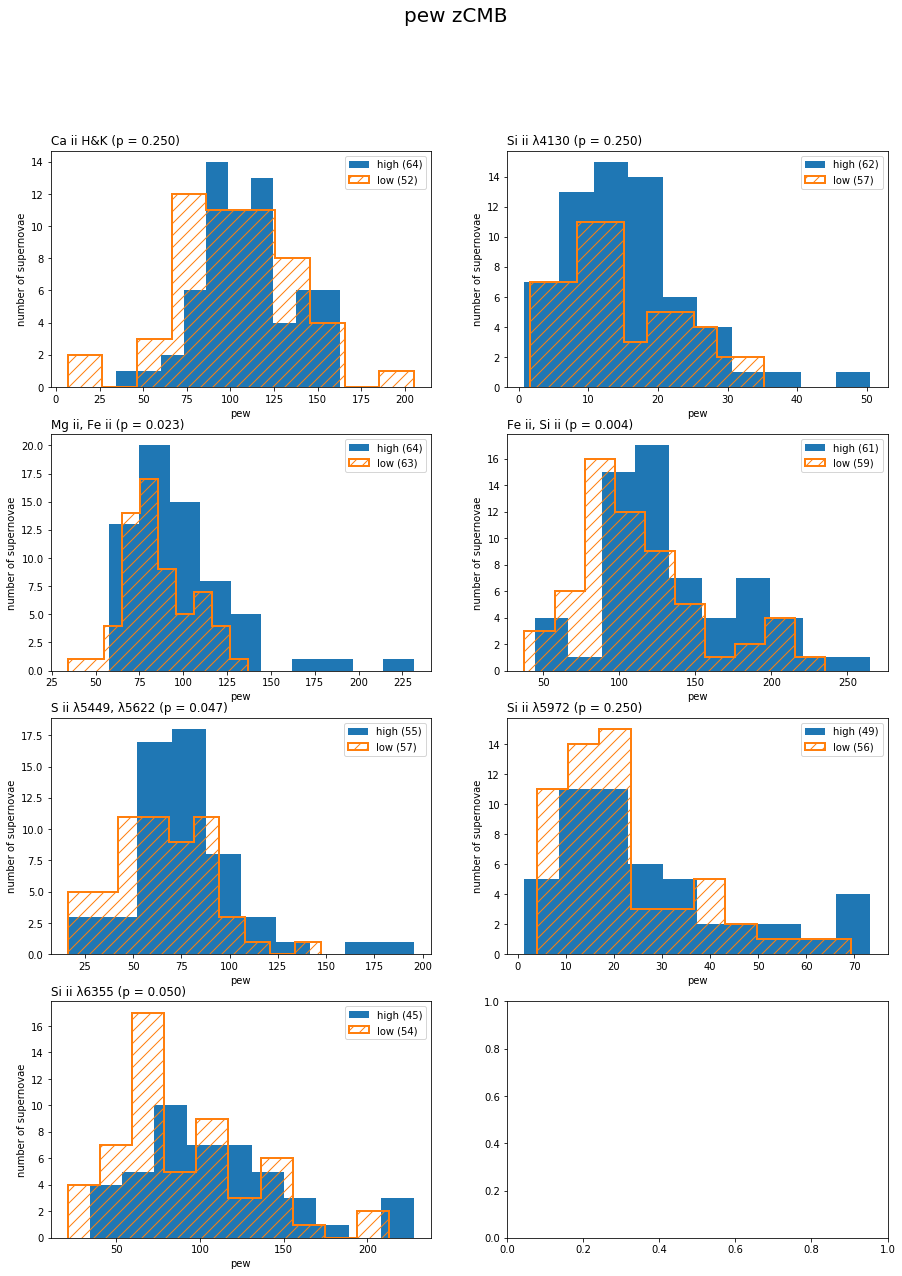

In [39]:
make_hist(high_zCMB, low_zCMB, 'pew', 'pew zCMB', 10)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: UserWarning: p-value capped: true value larger than 0.25


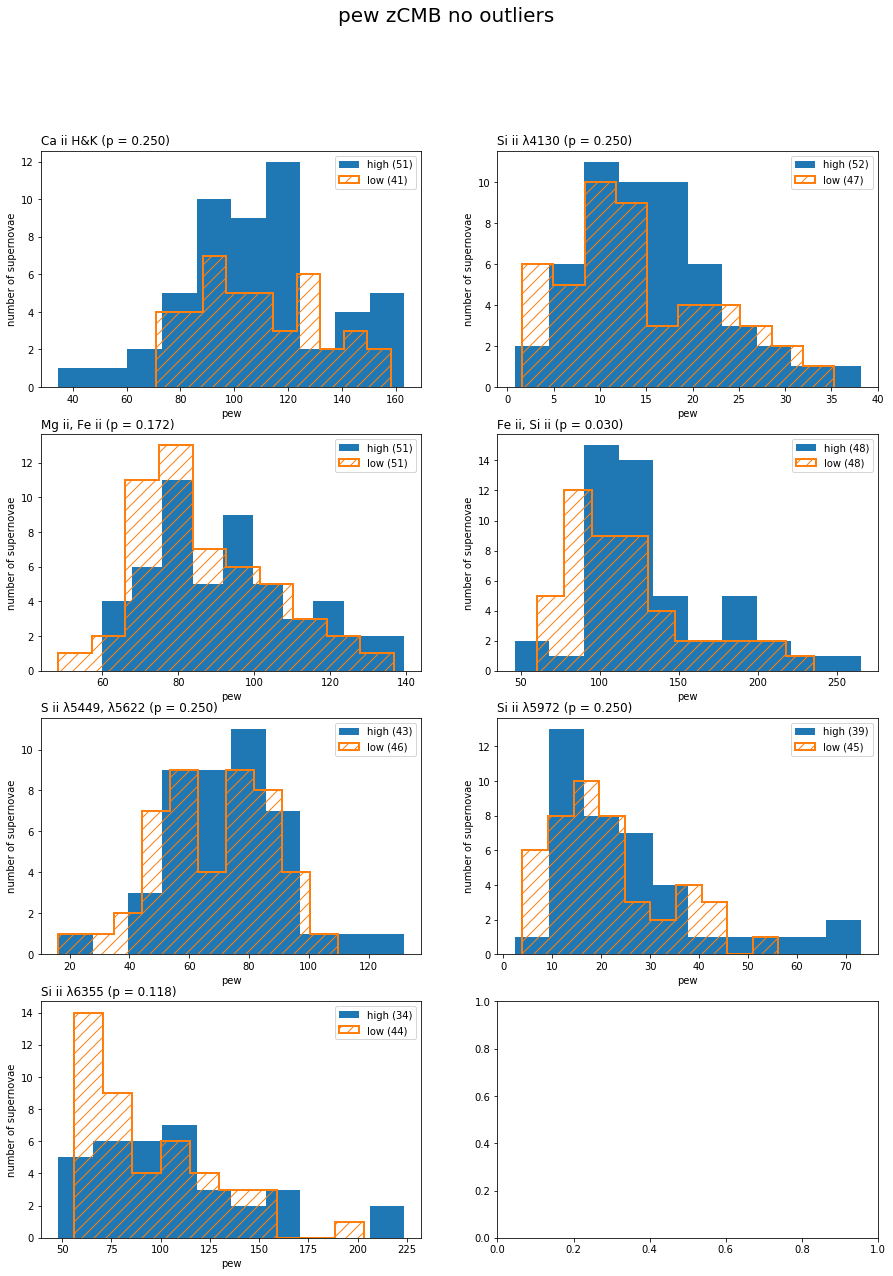

In [92]:
make_hist(high_zCMB_no, low_zCMB_no, 'pew', 'pew zCMB no outliers', 10)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: p-value capped: true value larger than 0.25
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: p-value floored: true value smaller than 0.001


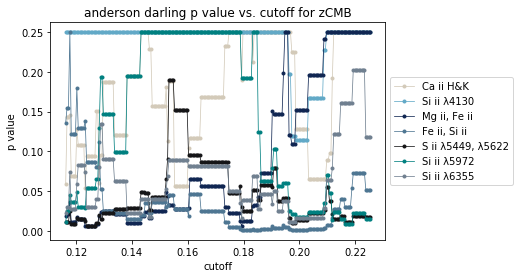

In [10]:
make_p_plot(sdss_combined, 'pew', 'zCMB')

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: UserWarning: p-value capped: true value larger than 0.25
/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:829: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:830: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


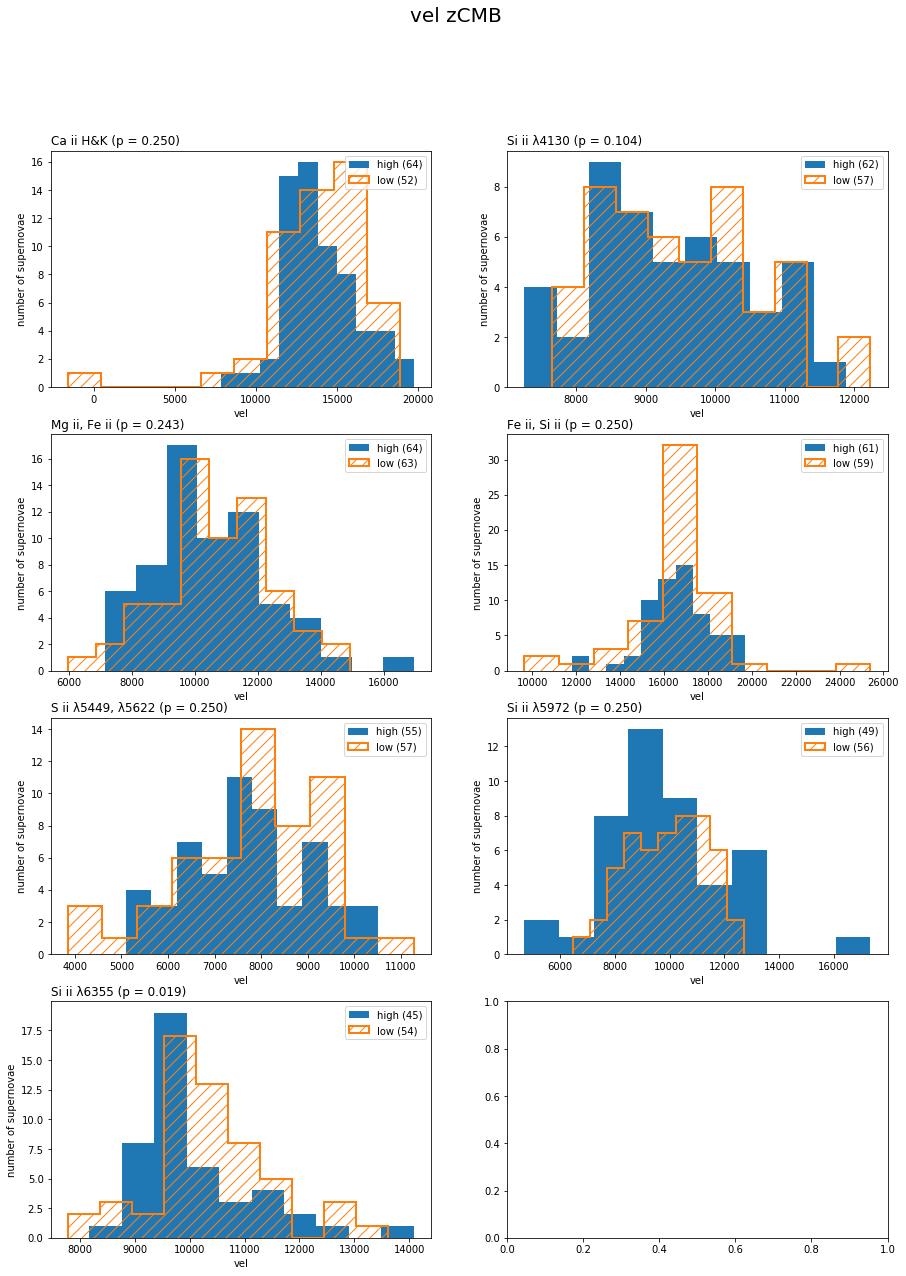

In [41]:
make_hist(high_zCMB, low_zCMB, 'vel', 'vel zCMB', 10)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: UserWarning: p-value capped: true value larger than 0.25


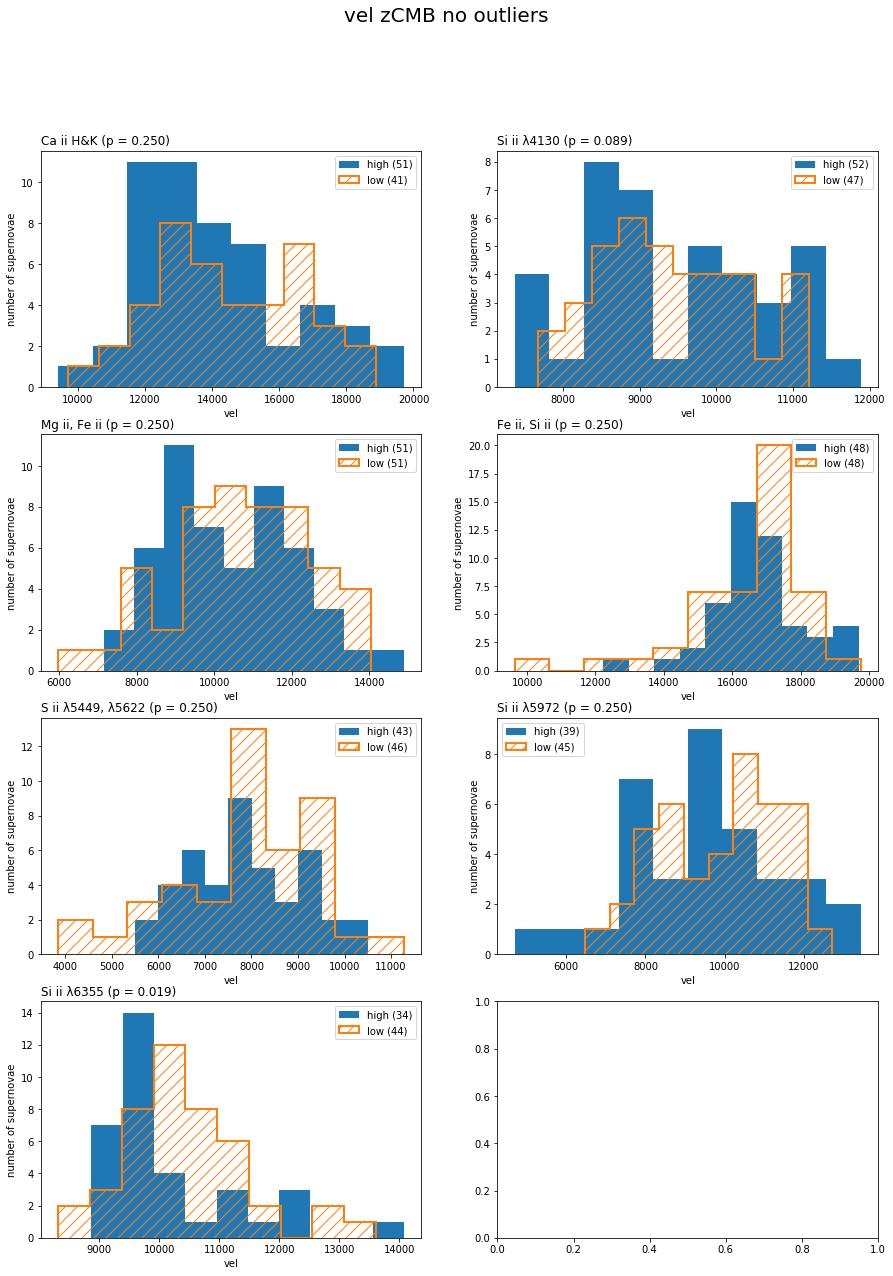

In [93]:
make_hist(high_zCMB_no, low_zCMB_no, 'vel', 'vel zCMB no outliers', 10)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: p-value capped: true value larger than 0.25


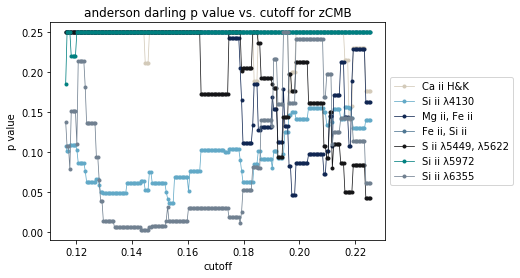

In [43]:
make_p_plot(sdss_combined, 'vel', 'zCMB')

# low mass high mass

In [94]:
logMass_p_comparison = anderson_df(high_logMass, low_logMass, high_logMass_no, low_logMass_no)
logMass_p_comparison

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: p-value capped: true value larger than 0.25
  if __name__ == '__main__':
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: p-value capped: true value larger than 0.25
  # Remove the CWD from sys.path while we load stuff.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: p-value capped: true value larger than 0.25
  
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: p-value capped: true value larger than 0.25
  from ipykernel import kernelapp as app


,feature,pew_p_val,NO_pew_p_val,vel_p_val,NO_vel_p_val
0,Ca ii H&K,0.250000,0.250000,0.250000,0.250000
1,Si ii λ4130,0.096035,0.021714,0.065001,0.100913
2,"Mg ii, Fe ii",0.129163,0.250000,0.188343,0.250000
3,"Fe ii, Si ii",0.250000,0.250000,0.250000,0.250000
4,"S ii λ5449, λ5622",0.070245,0.250000,0.250000,0.250000
5,Si ii λ5972,0.250000,0.250000,0.145737,0.250000
6,Si ii λ6355,0.250000,0.250000,0.078522,0.085308


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: UserWarning: p-value capped: true value larger than 0.25


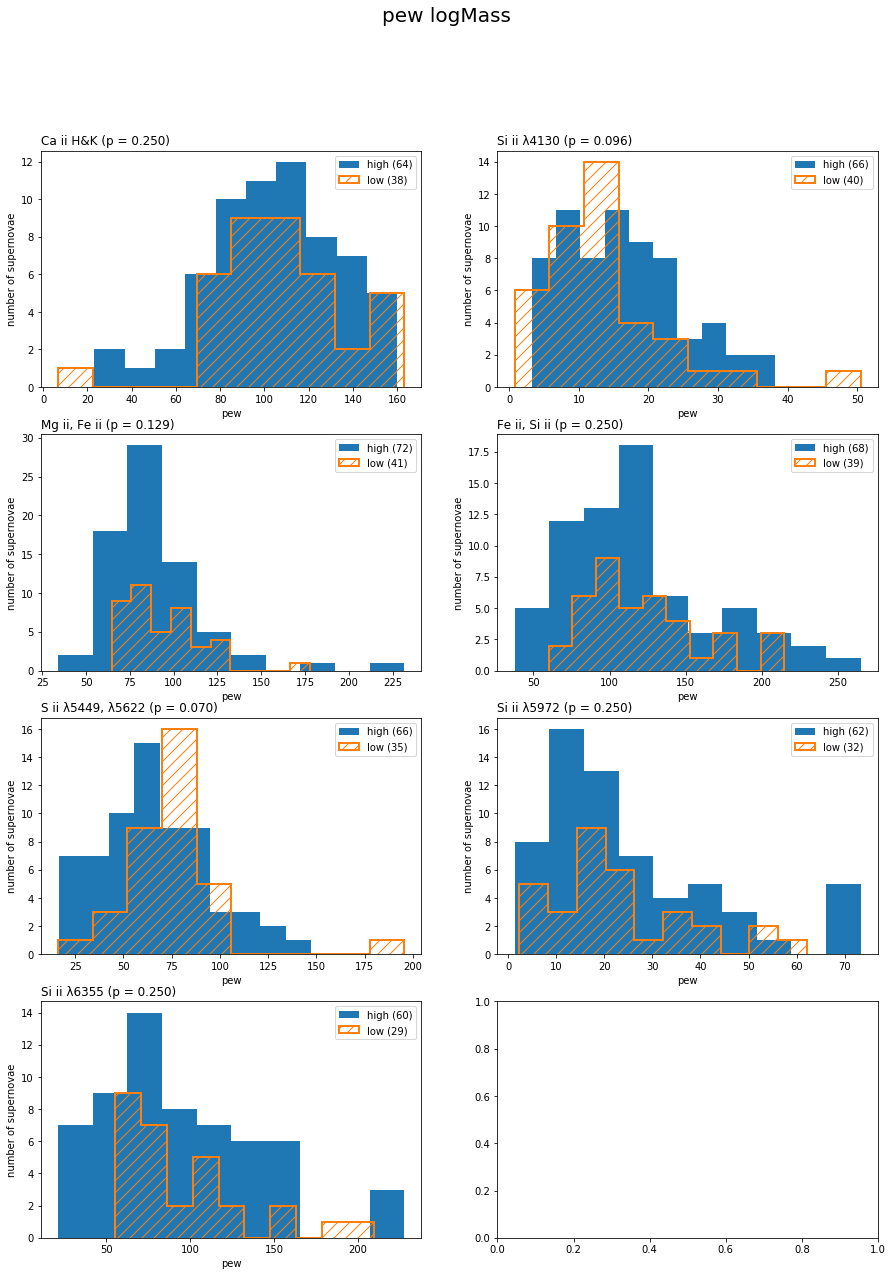

In [44]:
make_hist(high_logMass, low_logMass, 'pew', 'pew logMass', 10)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: UserWarning: p-value capped: true value larger than 0.25


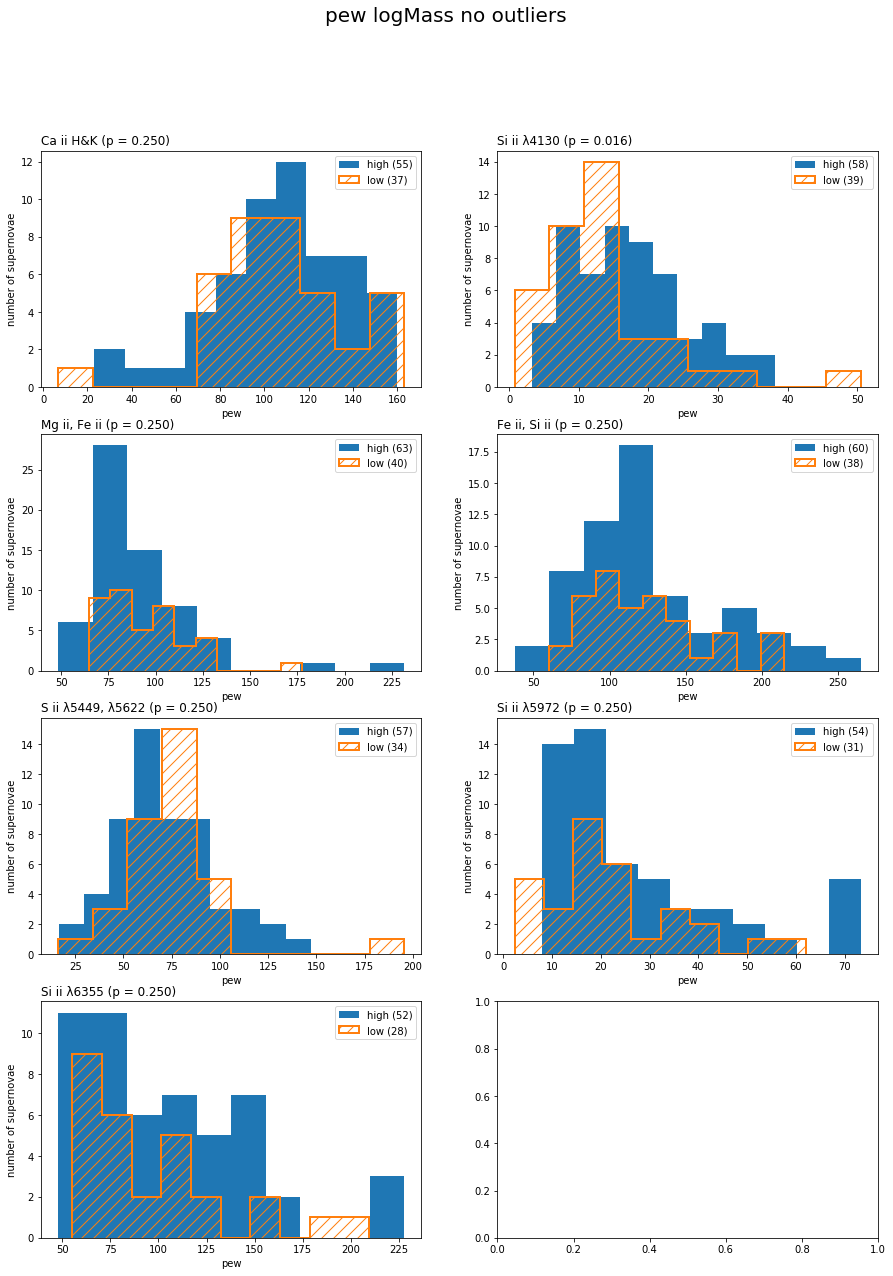

In [45]:
make_hist(high_logMass_no, low_logMass_no, 'pew', 'pew logMass no outliers', 10)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: p-value capped: true value larger than 0.25
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: p-value floored: true value smaller than 0.001


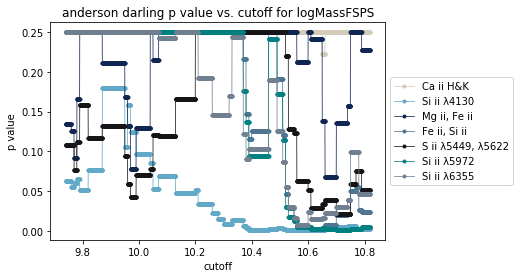

In [14]:
make_p_plot(sdss_combined, 'pew', 'logMassFSPS')

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: UserWarning: p-value capped: true value larger than 0.25


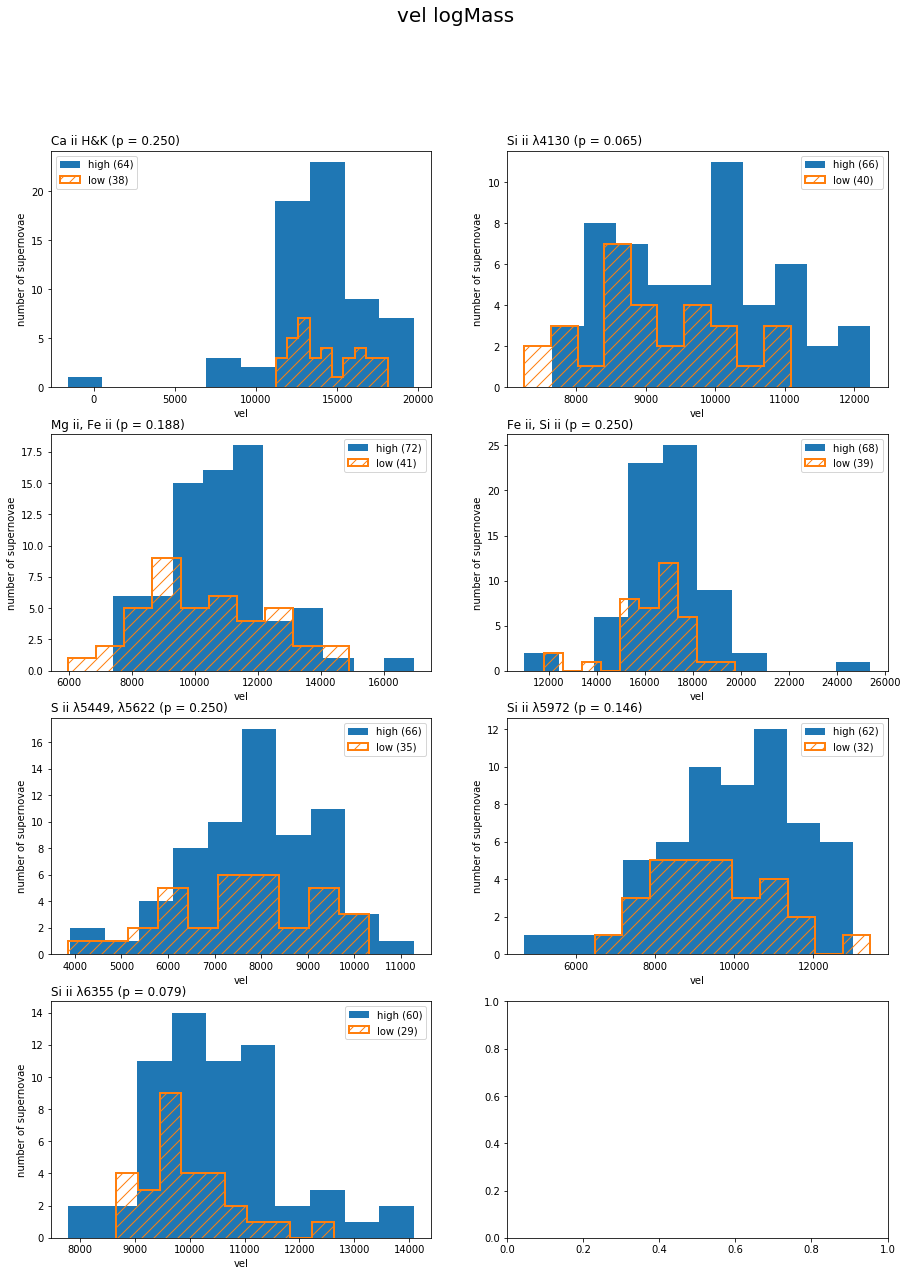

In [46]:
make_hist(high_logMass, low_logMass, 'vel', 'vel logMass', 10)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: UserWarning: p-value capped: true value larger than 0.25


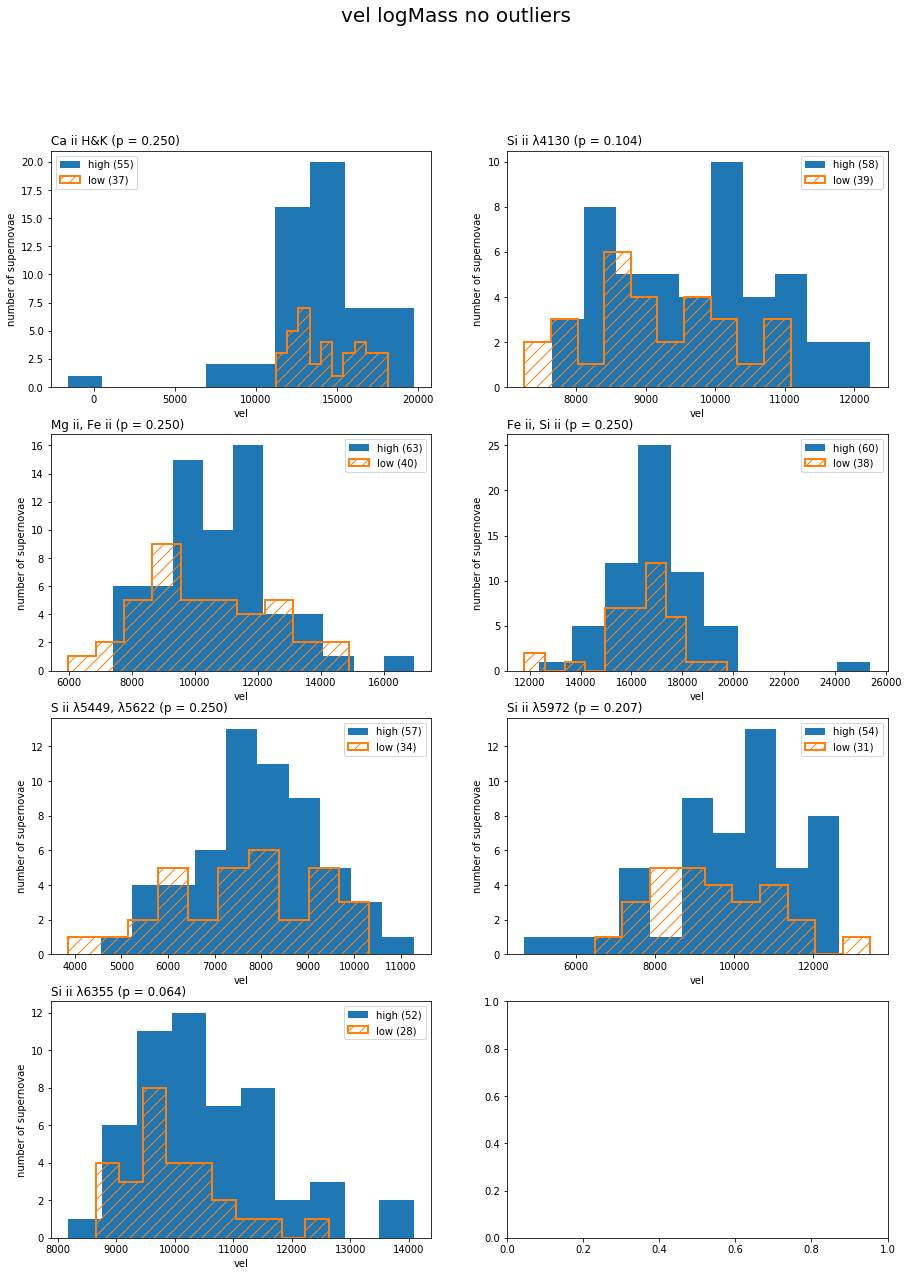

In [47]:
make_hist(high_logMass_no, low_logMass_no, 'vel', 'vel logMass no outliers', 10)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: p-value capped: true value larger than 0.25


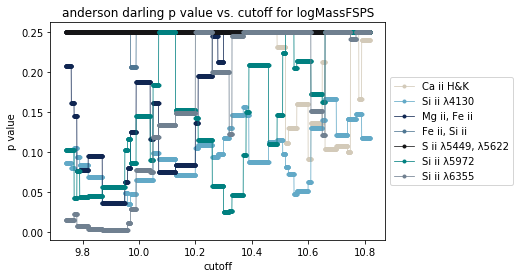

In [16]:
make_p_plot(sdss_combined, 'vel', 'logMassFSPS')

# low SFR high SFR

In [95]:
SSFR_p_comparison = anderson_df(high_logSSFR, low_logSSFR, high_logSSFR_no, low_logSSFR_no)
SSFR_p_comparison

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: p-value capped: true value larger than 0.25
  if __name__ == '__main__':
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: p-value floored: true value smaller than 0.001
  if __name__ == '__main__':
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: p-value capped: true value larger than 0.25
  
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: p-value capped: true value larger than 0.25
  from ipykernel import kernelapp as app


,feature,pew_p_val,NO_pew_p_val,vel_p_val,NO_vel_p_val
0,Ca ii H&K,0.250000,0.250000,0.025356,0.222139
1,Si ii λ4130,0.001000,0.001264,0.166518,0.131865
2,"Mg ii, Fe ii",0.250000,0.250000,0.146361,0.046882
3,"Fe ii, Si ii",0.017591,0.001382,0.080911,0.250000
4,"S ii λ5449, λ5622",0.250000,0.250000,0.076333,0.250000
5,Si ii λ5972,0.135012,0.095981,0.019765,0.062585
6,Si ii λ6355,0.234181,0.250000,0.042539,0.054018


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: UserWarning: p-value capped: true value larger than 0.25
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: UserWarning: p-value floored: true value smaller than 0.001


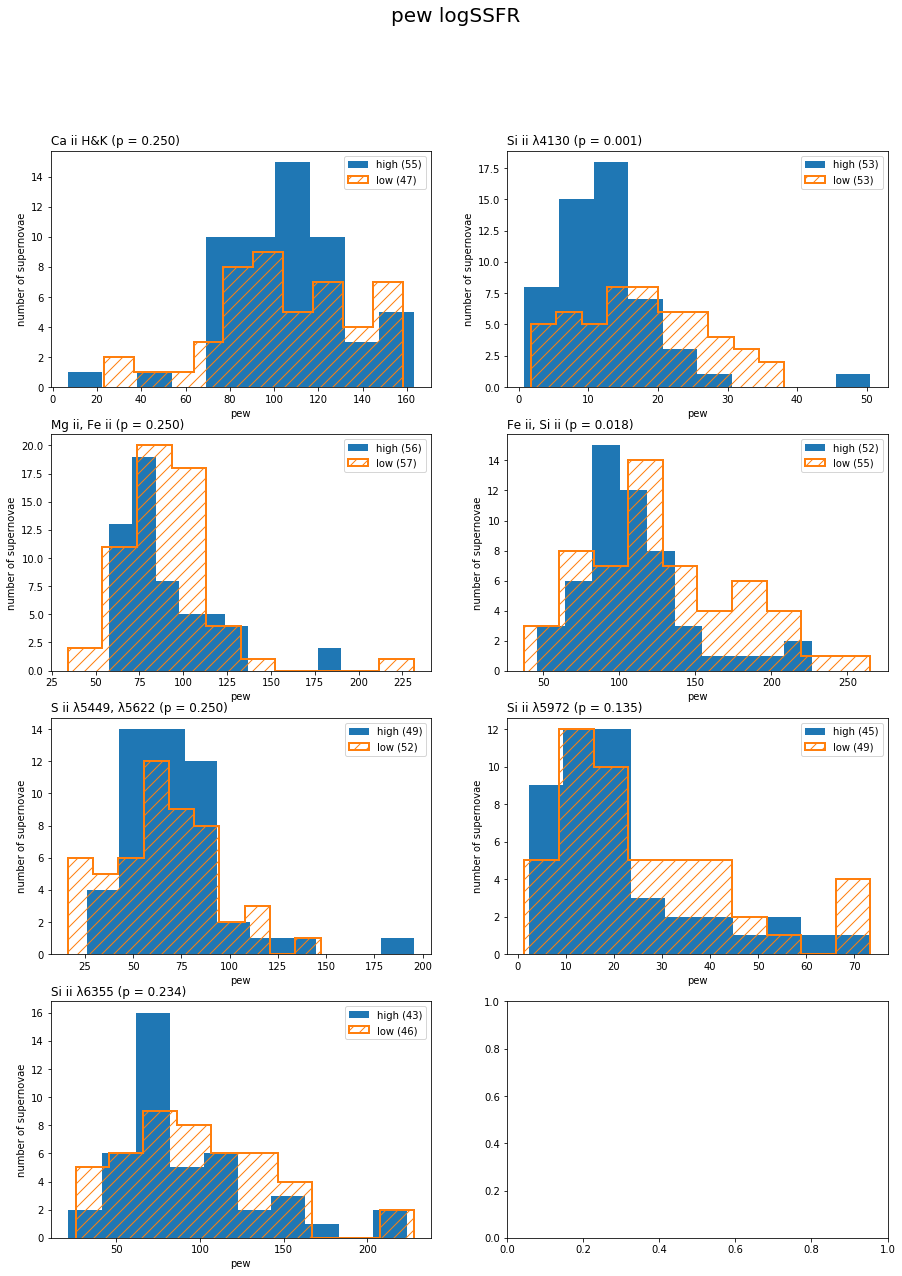

In [48]:
make_hist(high_logSSFR, low_logSSFR, 'pew', 'pew logSSFR', 10)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: UserWarning: p-value capped: true value larger than 0.25


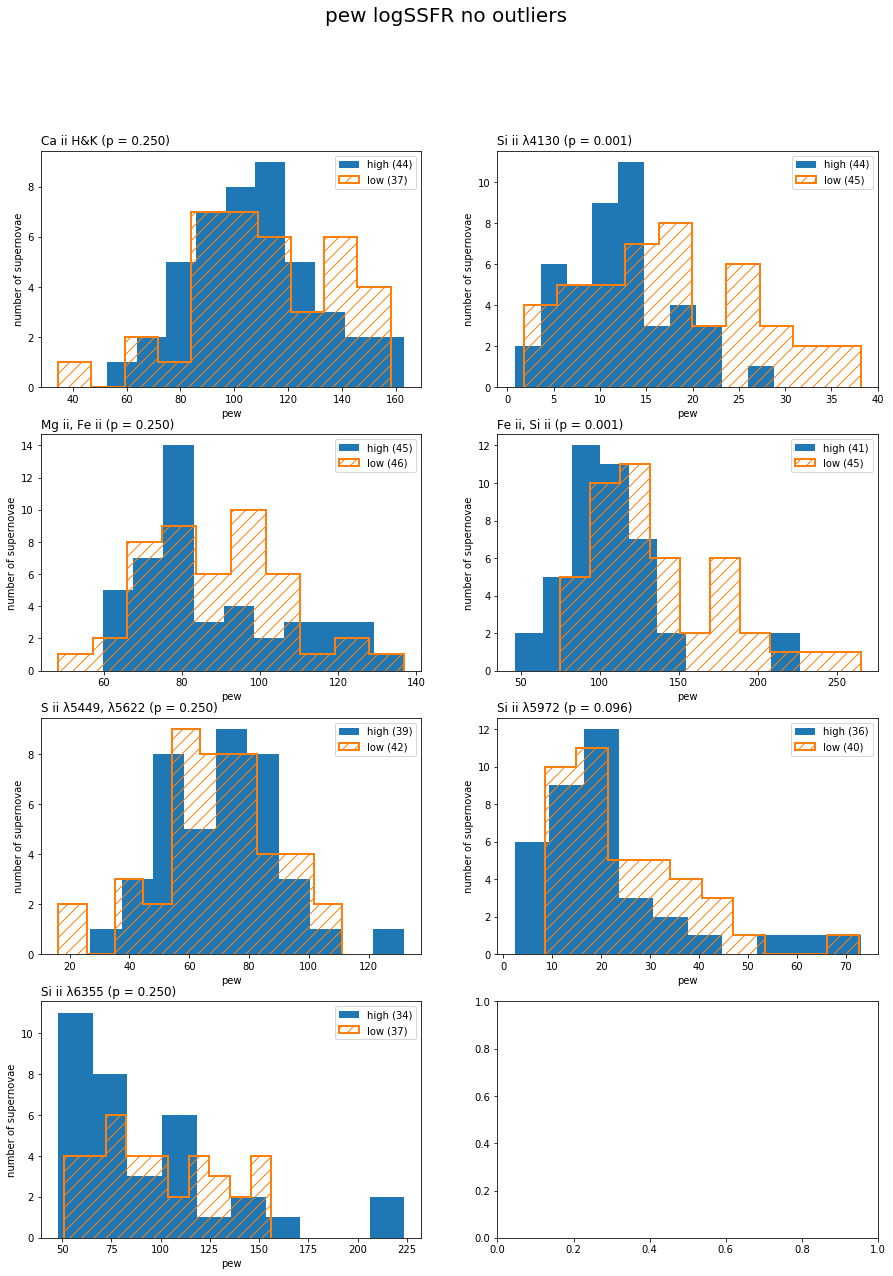

In [96]:
make_hist(high_logSSFR_no, low_logSSFR_no, 'pew', 'pew logSSFR no outliers', 10)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: p-value capped: true value larger than 0.25
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: p-value floored: true value smaller than 0.001


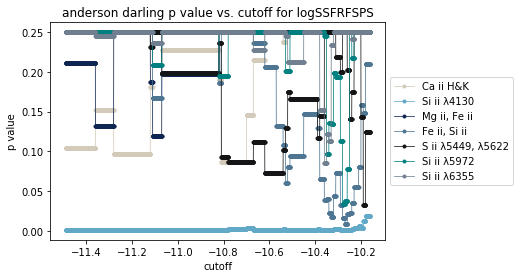

In [18]:
make_p_plot(sdss_combined, 'pew', 'logSSFRFSPS')

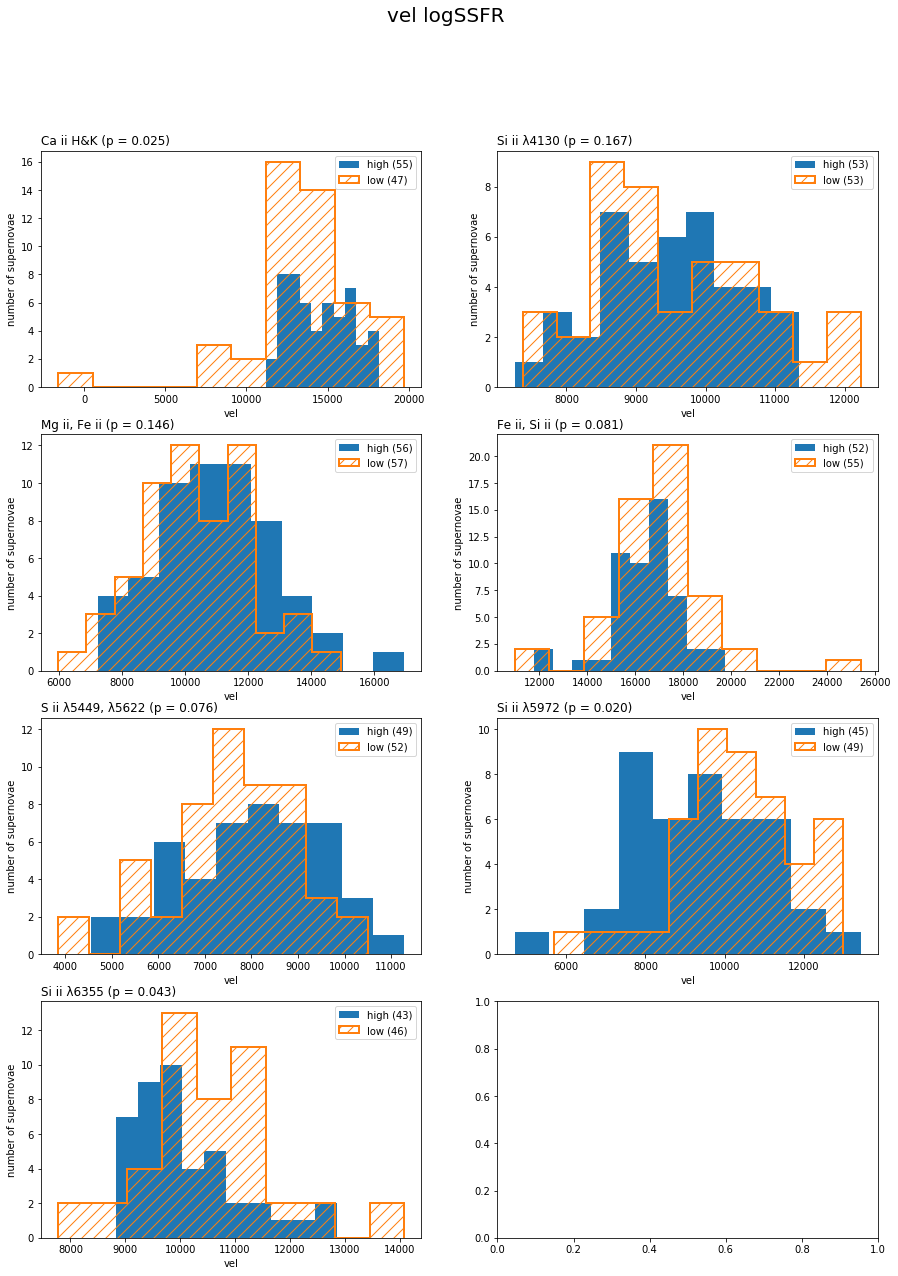

In [50]:
make_hist(high_logSSFR, low_logSSFR, 'vel', 'vel logSSFR', 10)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: UserWarning: p-value capped: true value larger than 0.25


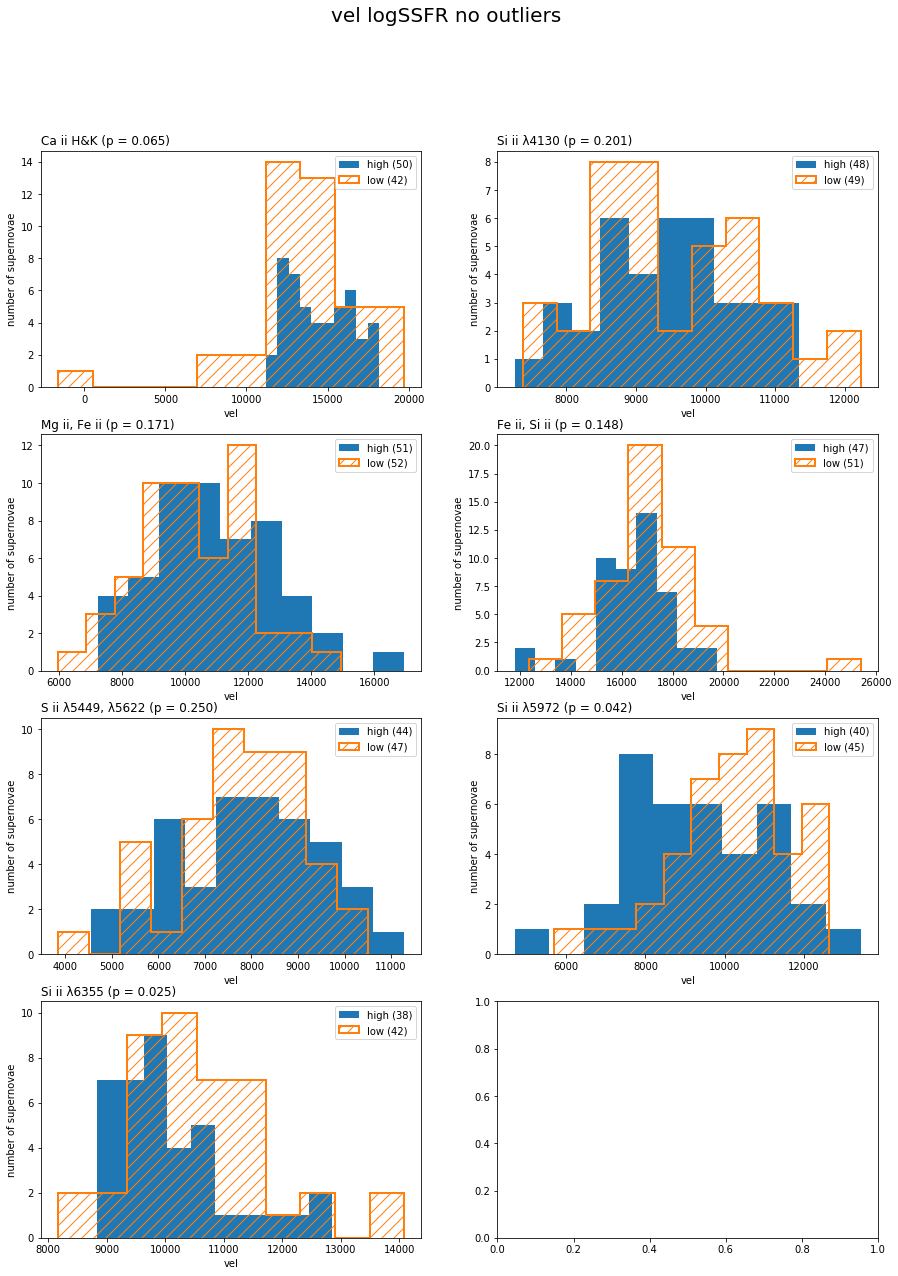

In [51]:
make_hist(high_logSSFR_no, low_logSSFR_no, 'vel', 'vel logSSFR no outliers', 10)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: p-value capped: true value larger than 0.25


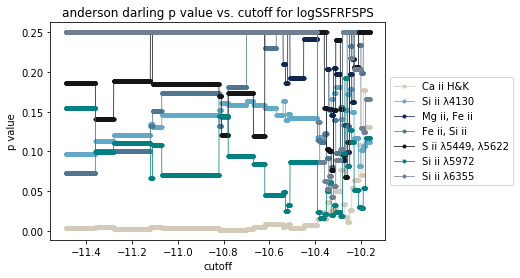

In [20]:
make_p_plot(sdss_combined, 'vel', 'logSSFRFSPS')